In [190]:
import time
from datetime import datetime
import pickle
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [191]:
data_raw = pd.read_excel("/Users/kirillkuznecov/my_docks/macro_parser/LME/parser_beta_2.0/data/nbk_tenge.xlsx", index_col=0)

In [192]:
data = data_raw[data_raw["date"] < pd.to_datetime("2024-10-01")]
data_check = data_raw[data_raw["date"] > pd.to_datetime("2024-10-01")]

In [193]:
data = data.set_index("date").drop(columns=["Числовое значение"])
data_check = data_check.set_index("date").drop(columns=["Числовое значение"])
data

,ДОЛЛАР США
date,
2022-01-01,431.80
2022-01-02,431.80
2022-01-03,431.80
2022-01-04,431.80
2022-01-05,431.80
...,...
2024-09-26,478.16
2024-09-27,478.54
2024-09-28,479.23


In [194]:
data = data.resample('M').mean()
data_check = data_check.resample('M').mean()
data

,ДОЛЛАР США
date,
2022-01-31,433.421935
2022-02-28,435.844286
2022-03-31,499.749355
2022-04-30,453.384333
2022-05-31,431.818065
2022-06-30,443.421667
2022-07-31,476.008710
2022-08-31,474.443871
2022-09-30,475.576333


<Axes: xlabel='date'>

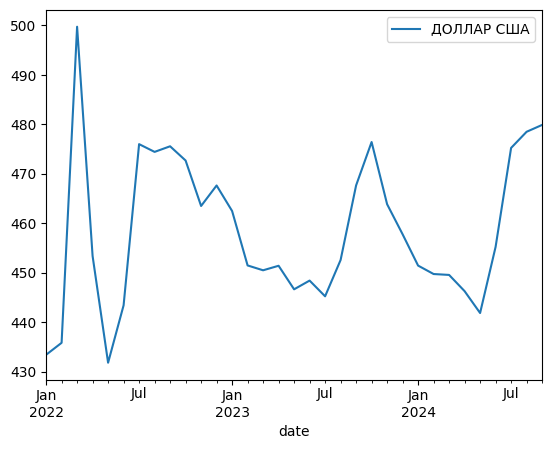

In [195]:
interpolated_data = data
interpolated_data.plot()

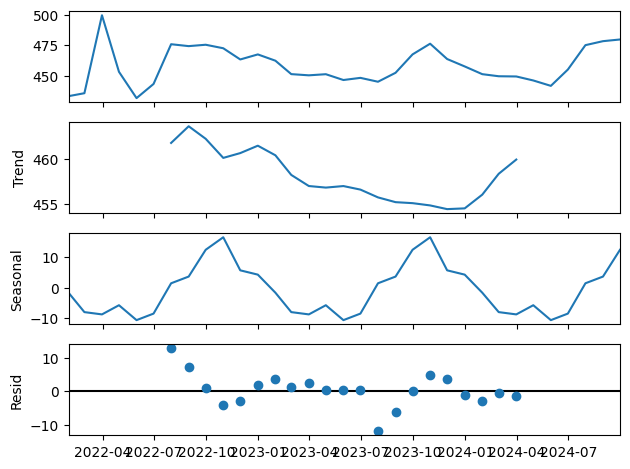

In [196]:
decompose = seasonal_decompose(interpolated_data)
decompose.plot()
plt.show()

In [197]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

Есть единичные корни, ряд не стационарен
{'p_value': -2.5824557401727977, 'crit_value (5%)': -3.005425537190083}


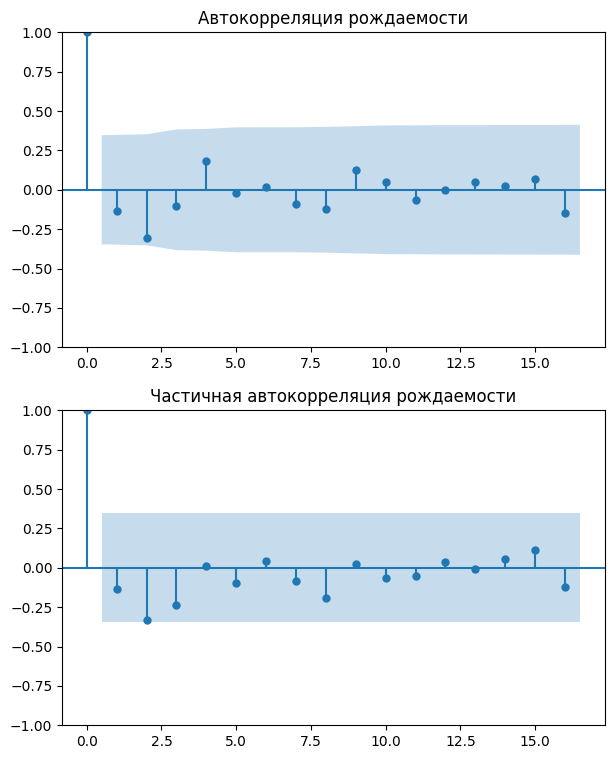

In [198]:
stationary_test(interpolated_data.diff().dropna(), name='рождаемости')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=242.051, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=240.229, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=243.881, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=242.433, Time=0.02 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=242.141, Time=0.01 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=inf, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=242.125, Time=0.00 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=242.056, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=243.778, Time=0.01 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=242.035, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 0.151 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   33
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 4)   Log

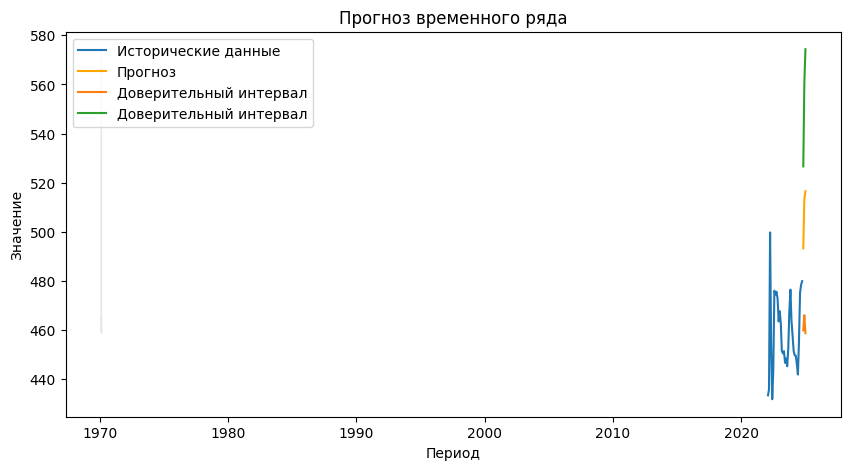

In [199]:
model_1 = pm.auto_arima(
    interpolated_data,
    start_p=0,
    start_q=0,
    test="adf",
    max_p=50,
    max_q=50,
    m=4,
    start_P=0,
    seasonal=True,
    stationary=False,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)

print(model_1.summary())

# Прогнозирование
# Задаем количество периодов для прогнозирования
n_periods = 3  # например, прогноз на следующих 50 периодов
forecast, conf_int = model_1.predict(n_periods=n_periods, return_conf_int=True)

# Создаем индексы для прогнозируемых периодов, предполагаем, что индексы - это временные метки
index_of_fc = np.arange(len(interpolated_data), len(interpolated_data) + n_periods)

# Создаем DataFrame для визуализации результата
forecast_df = (
    pd.DataFrame(forecast)
    .reset_index()
    .set_axis(["year", "population"], axis=1)
    .set_index("year")
)

conf_int_df = pd.DataFrame(conf_int, index=forecast_df.index).set_axis(
    ["low_bound", "high_bound"], axis=1
)

# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(interpolated_data, label="Исторические данные")
plt.plot(forecast_df, label="Прогноз", color="orange")
plt.plot(conf_int_df, label="Доверительный интервал")
plt.fill_between(
    index_of_fc, conf_int[:, 0], conf_int[:, 1], color="lightgray", alpha=0.5
)
plt.title("Прогноз временного ряда")
plt.xlabel("Период")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [200]:
test = interpolated_data.iloc[-3:]
train = interpolated_data.iloc[:-3]

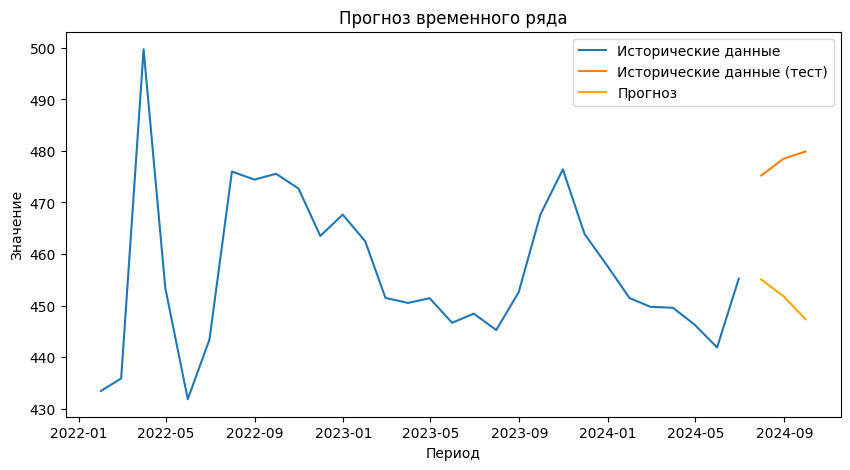

In [201]:
model_2 = ARIMA(train, order=model_1.order, seasonal_order=model_1.seasonal_order)  # Передаем временной ряд data как endog
model_2_fit = model_2.fit()

# Получаем прогнозы
n_forecast = 3  # Количество периодов для прогноза
forecast_2 = model_2_fit.forecast(steps=n_forecast)

# Создаем DataFrame для визуализации результата
forecast_df_2 = (
    pd.DataFrame(forecast_2)
    .reset_index()
    .set_axis(["year", "population"], axis=1)
    .set_index("year")
)



# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(train, label="Исторические данные")
plt.plot(test, label="Исторические данные (тест)")
plt.plot(forecast_df_2, label="Прогноз", color="orange")

plt.title("Прогноз временного ряда")
plt.xlabel("Период")
plt.ylabel("Значение")
plt.legend()
plt.show()

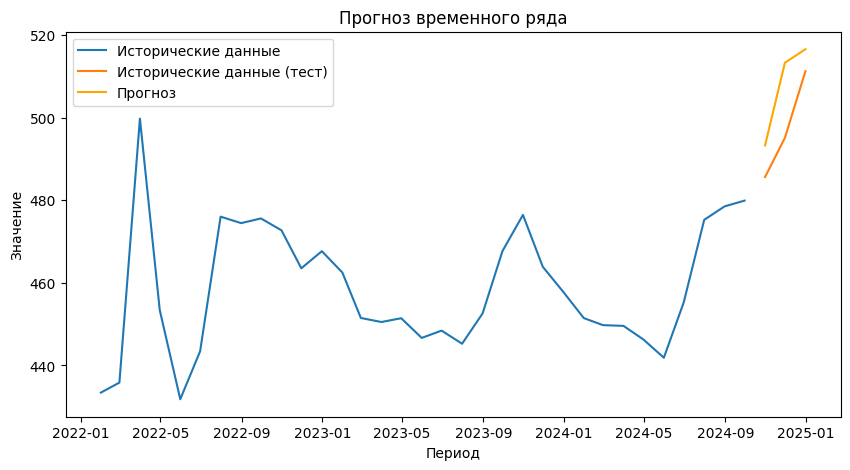

In [202]:
# Прогноз 4 кв
model_3 = ARIMA(data, order=model_1.order, seasonal_order=model_1.seasonal_order)  # Передаем временной ряд data как endog
model_3_fit = model_3.fit()

# Получаем прогнозы
n_forecast = 3  # Количество периодов для прогноза
forecast_3 = model_3_fit.forecast(steps=n_forecast)

# Создаем DataFrame для визуализации результата
forecast_df_3 = (
    pd.DataFrame(forecast_3)
    .reset_index()
    .set_axis(["year", "population"], axis=1)
    .set_index("year")
)



# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(data, label="Исторические данные")
plt.plot(data_check, label="Исторические данные (тест)")
plt.plot(forecast_df_3, label="Прогноз", color="orange")

plt.title("Прогноз временного ряда")
plt.xlabel("Период")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [203]:
forecast_df_3.mean()

population    507.689416
dtype: float64

In [204]:
data_check.mean()

ДОЛЛАР США    497.308111
dtype: float64

In [205]:
data_check

,ДОЛЛАР США
date,
2024-10-31,485.609333
2024-11-30,495.095000
2024-12-31,511.220000


---

In [206]:
df = pd.read_excel("./data/RC_F01_01_2010_T30_11_2024.xlsx", index_col=1)
df = df["curs"]
df

data
2024-11-30    21.0021
2024-11-29    21.9371
2024-11-28    21.6649
2024-11-27    21.0749
2024-11-26    20.8273
               ...   
2010-01-15    19.8730
2010-01-14    20.0182
2010-01-13    19.8349
2010-01-12    19.8612
2010-01-01    20.3239
Name: curs, Length: 3687, dtype: float64

data
2010-01-31    20.140018
2010-02-28    20.420176
2010-03-31    20.099526
2010-04-30    19.895570
2010-05-31    20.707598
                ...    
2024-07-31    18.415642
2024-08-31    18.624735
2024-09-30    19.027860
2024-10-31    19.812571
2024-11-30    20.317383
Freq: ME, Name: curs, Length: 179, dtype: float64

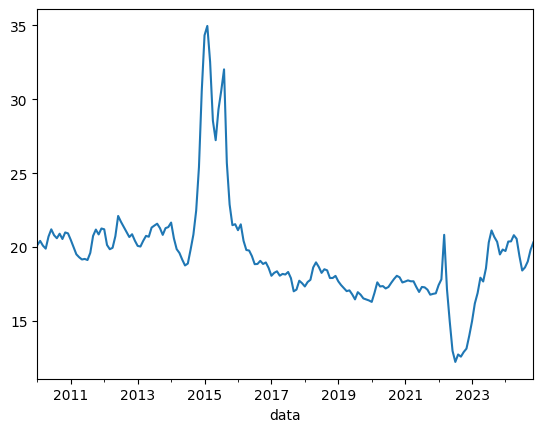

In [207]:
interpolated_data = df.resample("d").mean().interpolate(method="linear")
interpolated_data = interpolated_data.resample('M').mean()
interpolated_data.plot()
display(interpolated_data)

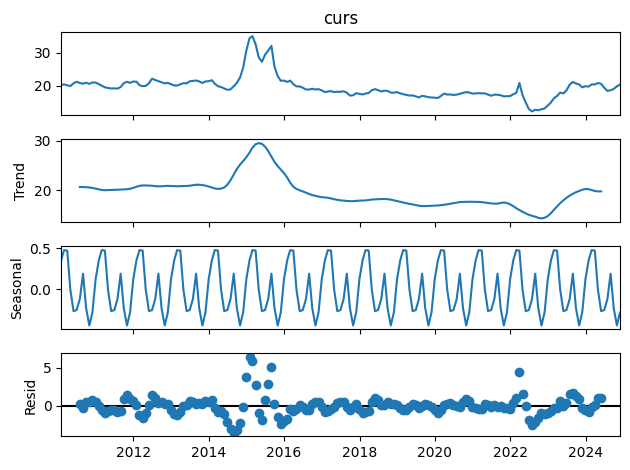

In [208]:
decompose = seasonal_decompose(interpolated_data)
decompose.plot()
plt.show()

In [217]:
test_check = interpolated_data.iloc[-2:]
train = interpolated_data.iloc[:-3]
test = train[-3:]
test


data
2024-06-30    19.399698
2024-07-31    18.415642
2024-08-31    18.624735
Freq: ME, Name: curs, dtype: float64

In [218]:
train

data
2010-01-31    20.140018
2010-02-28    20.420176
2010-03-31    20.099526
2010-04-30    19.895570
2010-05-31    20.707598
                ...    
2024-04-30    20.805653
2024-05-31    20.561442
2024-06-30    19.399698
2024-07-31    18.415642
2024-08-31    18.624735
Freq: ME, Name: curs, Length: 176, dtype: float64

In [219]:
test_check

data
2024-10-31    19.812571
2024-11-30    20.317383
Freq: ME, Name: curs, dtype: float64

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=533.680, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=498.917, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=502.036, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=531.680, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=496.295, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=485.769, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=486.584, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=487.202, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=493.863, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=487.096, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=483.770, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=494.295, Time=0.01 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=484.585, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=485.202, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=491.8

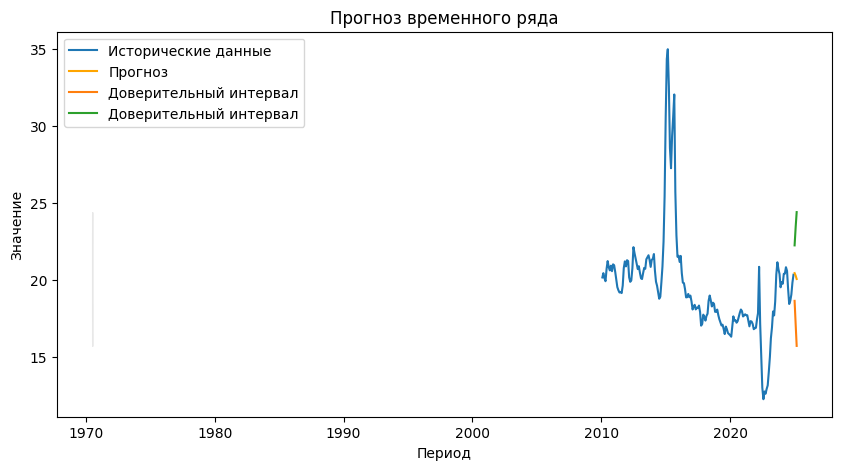

In [210]:
model_1 = pm.auto_arima(
    interpolated_data,
    start_p=0,
    start_q=0,
    test="adf",
    max_p=50,
    max_q=50,
    m=1,
    start_P=0,
    seasonal=True,
    stationary=False,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)

print(model_1.summary())

# Прогнозирование
# Задаем количество периодов для прогнозирования
n_periods = 3  # например, прогноз на следующих 50 периодов
forecast, conf_int = model_1.predict(n_periods=n_periods, return_conf_int=True)

# Создаем индексы для прогнозируемых периодов, предполагаем, что индексы - это временные метки
index_of_fc = np.arange(len(interpolated_data), len(interpolated_data) + n_periods)

# Создаем DataFrame для визуализации результата
forecast_df = (
    pd.DataFrame(forecast)
    .reset_index()
    .set_axis(["year", "population"], axis=1)
    .set_index("year")
)

conf_int_df = pd.DataFrame(conf_int, index=forecast_df.index).set_axis(
    ["low_bound", "high_bound"], axis=1
)

# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(interpolated_data, label="Исторические данные")
plt.plot(forecast_df, label="Прогноз", color="orange")
plt.plot(conf_int_df, label="Доверительный интервал")
plt.fill_between(
    index_of_fc, conf_int[:, 0], conf_int[:, 1], color="lightgray", alpha=0.5
)
plt.title("Прогноз временного ряда")
plt.xlabel("Период")
plt.ylabel("Значение")
plt.legend()
plt.show()

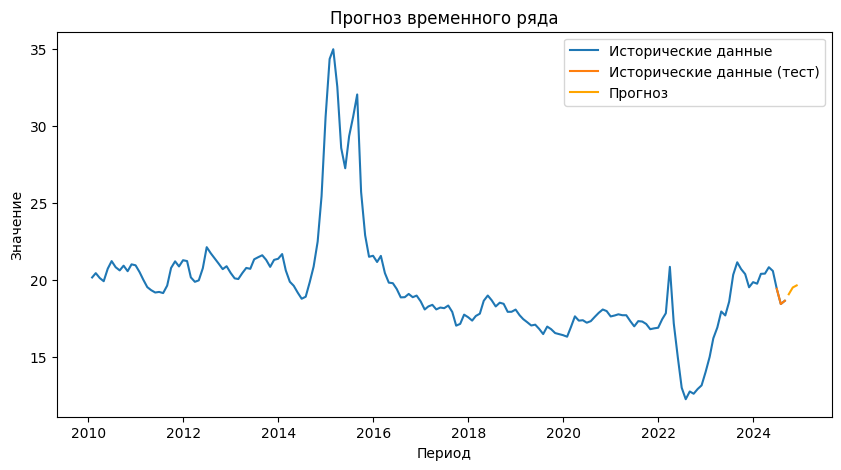

In [211]:
model_2 = ARIMA(train, order=model_1.order, seasonal_order=model_1.seasonal_order)  # Передаем временной ряд data как endog
model_2_fit = model_2.fit()

# Получаем прогнозы
n_forecast = 3  # Количество периодов для прогноза
forecast_2 = model_2_fit.forecast(steps=n_forecast)

# Создаем DataFrame для визуализации результата
forecast_df_2 = (
    pd.DataFrame(forecast_2)
    .reset_index()
    .set_axis(["year", "population"], axis=1)
    .set_index("year")
)



# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(train, label="Исторические данные")
plt.plot(test, label="Исторические данные (тест)")
plt.plot(forecast_df_2, label="Прогноз", color="orange")

plt.title("Прогноз временного ряда")
plt.xlabel("Период")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [212]:
display(forecast_df_2, test_check)

,population
year,
2024-09-30,19.048743
2024-10-31,19.489153
2024-11-30,19.623895


data
2024-10-31    19.812571
2024-11-30    20.317383
Freq: ME, Name: curs, dtype: float64

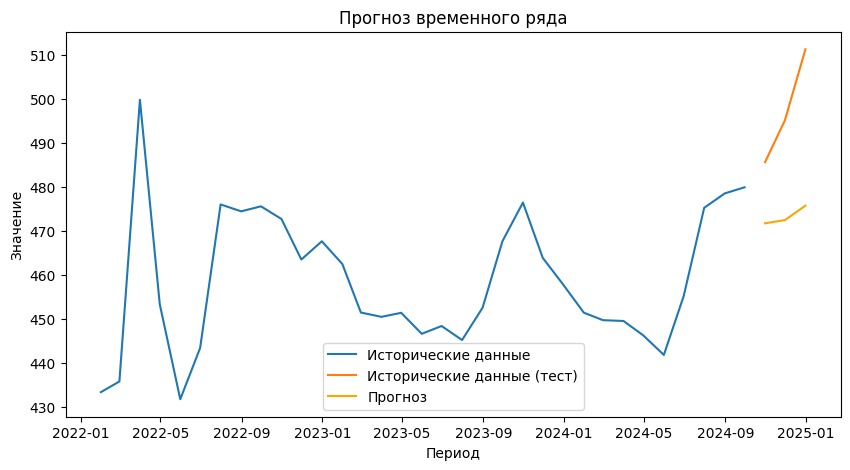

In [ ]:
model_2 = ARIMA(train, order=model_1.order, seasonal_order=model_1.seasonal_order)  # Передаем временной ряд data как endog
model_2_fit = model_2.fit()

# Получаем прогнозы
n_forecast = 3  # Количество периодов для прогноза
forecast_2 = model_2_fit.forecast(steps=n_forecast)

# Создаем DataFrame для визуализации результата
forecast_df_2 = (
    pd.DataFrame(forecast_2)
    .reset_index()
    .set_axis(["year", "population"], axis=1)
    .set_index("year")
)



# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(train, label="Исторические данные")
plt.plot(test, label="Исторические данные (тест)")
plt.plot(forecast_df_2, label="Прогноз", color="orange")

plt.title("Прогноз временного ряда")
plt.xlabel("Период")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [214]:
forecast_df_3.mean()

population    473.305951
dtype: float64